# Does GDP or GDP Per Capita influence Co2 Emissions more?

## Setting Enviorment

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, root_mean_squared_error
import joblib as jb

In [2]:
import os
os.chdir(os.path.expanduser("C:\\Users\\Nico\\Desktop\\Personal Projects Data Science\\Co2 predictions"))

from co2mdl import TrainModel, TrainSVR

In [3]:
#read in
df_all_raw = pd.read_csv('owid-co2-data.csv')
pop_raw = pd.read_csv('PopPrediction.csv')

In [4]:
#filtering
df_all = df_all_raw[df_all_raw['gdp'].isnull() == False]
df_all = df_all[df_all['co2'].isnull() == False]
df_all['gdp_per_capita'] = df_all['gdp']/df_all['population']

df_co2 = df_all[['iso_code','year','population','gdp','gdp_per_capita','co2']]

In [5]:
#filtering
pop = pop_raw[['location_name','year_id','scenario_name','val']]
pop = pop[pop['scenario_name'] == 'Reference'][['location_name','year_id','val']]
pop.columns = ['country', 'year','population']
pop = pop[pop['year'] >= 2023]

## United States of America

In [6]:
#Filter out data specifically for the United States
uspop = pop[pop['country'] == 'United States of America'][['year','population']]
dfusa = df_co2[df_co2['iso_code'] == 'USA']

Text(0.5, 1.0, 'US Population Prediction')

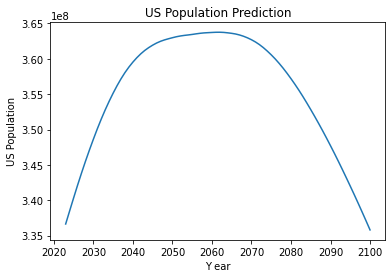

In [7]:
#Show the given population prediction for the United States
plt.plot(uspop['year'],uspop['population'])
plt.xlabel('Y ear')
plt.ylabel('US Population')
plt.title('US Population Prediction')
#plt.savefig('USAPop.jpeg')

In [8]:
#gdp features and target data
usa_Xgdp = dfusa[['year','population']]
usa_ygdp = dfusa['gdp']

In [9]:
#Training for the gdp machine training model

#usa_modelgdp = LinearRegression()
#usa_polygdp = PolynomialFeatures(degree=2)

#USAgdpModel = TrainModel(usa_modelgdp,usa_polygdp,usa_Xgdp,usa_ygdp,0.998)


In [10]:
USAgdpModel = jb.load('USA\\USA gdp Model')

modelusagdp, polyusagdp, usa_refgdp, usa_gdp_target, usa_gdp_test, usa_gdp_test_data = USAgdpModel
years_gdp, test_gdp, pred_gdp = usa_gdp_test_data
print(usa_gdp_test)

[0.9980607813233536, 209262544908.14694]


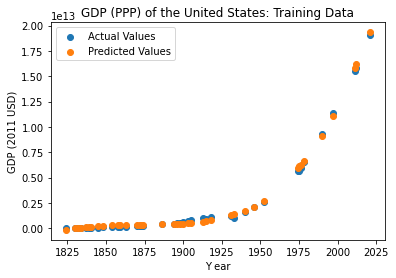

In [11]:
#Demonstrating the training data
plt.scatter(years_gdp,test_gdp, label='Actual Values')
plt.scatter(years_gdp,pred_gdp, label='Predicted Values')
plt.xlabel('Y ear')
plt.ylabel('GDP (2011 USD)')
plt.title('GDP (PPP) of the United States: Training Data')
plt.legend()
#plt.savefig('USAgdpTraining.jpeg')

In [12]:
#jb.dump(value = USAgdpModel, filename='USA GDP Model')

In [13]:
#Split into feature data and target data
usa_Xco2 = dfusa.drop(['iso_code','co2'], axis=1)
usa_yco2 = dfusa['co2']

Text(0.5, 1.0, 'Validation Curve')

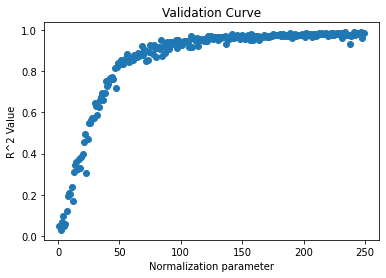

In [14]:
validation = []

for i in range(1,250):
    usa_modelco2 = SVR(C=(i+1))
    USAco2Model = TrainSVR(usa_modelco2, usa_Xco2, usa_yco2, threshold=0.01)
    modelusaco2, usa_refco2, usa_co2_target, usa_co2_test, usa_co2_test_data = USAco2Model
    validation.append(usa_co2_test[0])

c_vals = np.array(range(1,250))
validation = np.array(validation)

plt.scatter(c_vals,validation)
plt.xlabel('Normalization parameter')
plt.ylabel("R^2 Value")
plt.title('Validation Curve')
#plt.savefig('USAHyperparameterCurve.jpeg')

In [15]:
#Code used to train the linear regression model to predict Co2 in emmissions in the furture
#Commeted out after the training is complete

#usa_modelco2 = SVR(C=235)


#USAco2Model = TrainSVR(usa_modelco2,usa_Xco2,usa_yco2, threshold=0.99)

In [16]:
USAco2Model = jb.load('USA\\USA Co2 Model SVR')

modelusaco2, usa_refco2, usa_co2_target, usa_co2_test, usa_co2_test_data = USAco2Model
years_co2, test_co2, pred_co2 = usa_co2_test_data
print(usa_co2_test)

[0.9923897211394677, 205.12715621039104]


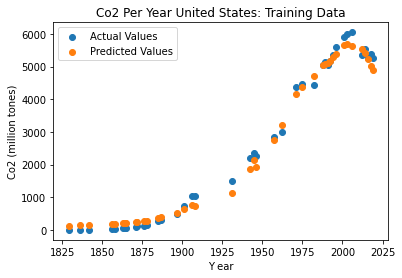

In [17]:
#Demonstrating the training data
plt.scatter(years_co2,test_co2, label='Actual Values')
plt.scatter(years_co2,pred_co2, label='Predicted Values')
plt.xlabel('Y ear')
plt.ylabel('Co2 (million tones)')
plt.title('Co2 Per Year United States: Training Data')
plt.legend()
#plt.savefig('USACo2Training.jpeg')

In [18]:
#jb.dump(value = USAco2Model, filename='USA Co2 Model SVR')

In [19]:
#Making predictions for future gdp based on population to be used in Co2 prediction
X_p = polyusagdp.transform(uspop)
future_gdp = modelusagdp.predict(X_p)

dfusa_future = pd.DataFrame({
    'iso_code': np.array(['USA']*len(np.arange(2023,2101))),
    'year': np.arange(2023,2101),
    'population': np.array(uspop['population']),
    'gdp': future_gdp.flatten(),
    'gdp_per_capita': future_gdp.flatten()/np.array(uspop['population'])
})

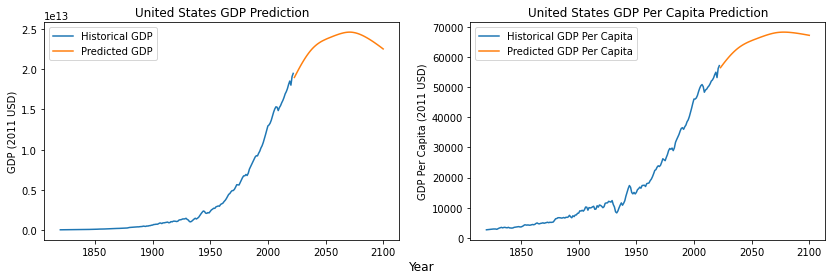

In [20]:
fig5, (ax11,ax12) = plt.subplots(1,2,sharex=True, figsize=(14,4))

ax11.plot(usa_Xgdp['year'],usa_ygdp, label='Historical GDP')
ax11.plot(dfusa_future['year'],dfusa_future['gdp'], label='Predicted GDP')
ax12.plot(dfusa['year'],dfusa['gdp_per_capita'], label='Historical GDP Per Capita')
ax12.plot(dfusa_future['year'], dfusa_future['gdp_per_capita'], label='Predicted GDP Per Capita')
fig5.supxlabel('Year')
ax11.set_ylabel('GDP (2011 USD)')
ax11.set_title('United States GDP Prediction')
ax12.set_ylabel('GDP Per Capita (2011 USD)')
ax12.set_title("United States GDP Per Capita Prediction")
ax11.legend()
ax12.legend()
#fig5.savefig('USAgdppercapitaGDP.jpeg')

In [21]:
#making prediction on the future co2 and putting it into the gdp prediction
X_usafut = dfusa_future.drop(['iso_code'], axis=1)
co2_fut = modelusaco2.predict(X_usafut)
dfusa_future['co2'] = co2_fut.flatten()

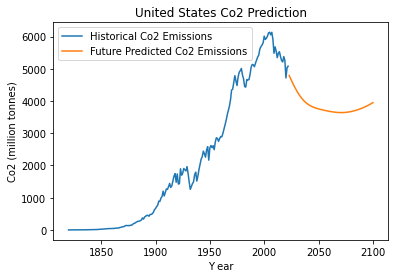

In [22]:
#Plotting the Co2 Prediction
plt.plot(dfusa['year'],dfusa['co2'], label='Historical Co2 Emissions')
plt.plot(dfusa_future['year'],dfusa_future['co2'], label='Future Predicted Co2 Emissions')
plt.xlabel('Y ear')
plt.ylabel('Co2 (million tonnes)')
plt.title('United States Co2 Prediction')
plt.legend()
#plt.savefig('USAco2Prediction.jpeg')

## Netherlands and Argentina

After looking at the United States we will compare different coutires based on gdp per capita and gdp to see what is more indicitive of drops in co2. The Netherlands and Argentina have similar gdps (ppp) and different gdp per capita (ppp).

In [23]:
nldpop = pop[pop['country'] == 'Netherlands'][['year','population']]
dfnld = df_co2[df_co2['iso_code'] == 'NLD']

In [24]:
argpop = pop[pop['country'] == 'Argentina'][['year','population']]
dfarg = df_co2[df_co2['iso_code'] == 'ARG']

Text(0.02, 0.5, 'Population')

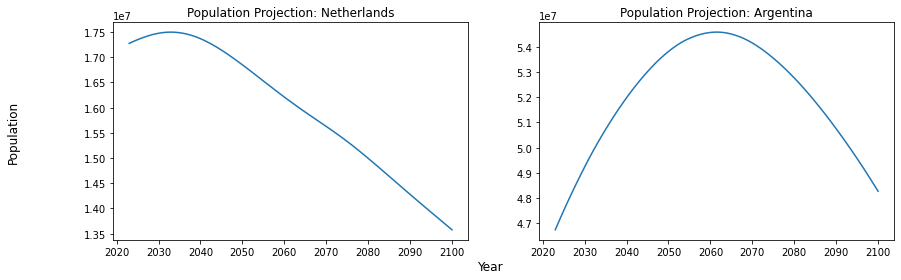

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(14,4))
ax1.plot(nldpop['year'], nldpop['population'])
ax2.plot(argpop['year'], argpop['population'])
ax1.set_title('Population Projection: Netherlands')
ax2.set_title('Population Projection: Argentina')
fig.supxlabel('Year')
fig.supylabel('Population')
#fig.savefig('NLDARGPop.jpeg')

## Netherlands

In [26]:
nld_Xgdp = dfnld[['year','population']]
nld_ygdp = dfnld['gdp']

In [27]:
#nld_modelgdp = LinearRegression()
#nld_polygdp = PolynomialFeatures(degree=2)

#NLDgdpModel = TrainModel(nld_modelgdp,nld_polygdp,nld_Xgdp,nld_ygdp,threshold=0.997)

In [28]:
NLDgdpModel = jb.load('NLD&ARG\\NLD GDP Model')

modelnldgdp, polynldgdp, nld_refgdp, nld_gdp_target, nld_gdp_test, nld_gdp_test_data = NLDgdpModel
years_gdp, test_gdp, pred_gdp = nld_gdp_test_data
print(nld_gdp_test)

[0.9971949424280248, 16146090580.890932]


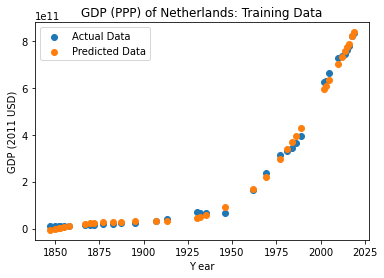

In [29]:
plt.scatter(years_gdp,test_gdp, label='Actual Data')
plt.scatter(years_gdp,pred_gdp, label='Predicted Data')
plt.title('GDP (PPP) of Netherlands: Training Data')
plt.xlabel('Y ear')
plt.ylabel('GDP (2011 USD)')
plt.legend()
#plt.savefig('NLDGDPTraining.jpeg')

In [30]:
#jb.dump(value=NLDgdpModel, filename='NLD GDP Model')

In [31]:
nld_Xco2 = dfnld.drop(['iso_code', 'co2'], axis=1)
nld_yco2 = dfnld['co2']

32 0.9959060275950122


Text(0.5, 1.0, 'Validation Curve')

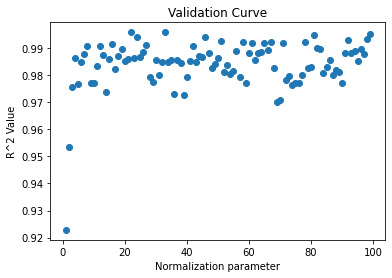

In [32]:
validation = []

for i in range(1,100):
    nld_modelco2 = SVR(C=(i+1))
    NLDco2Model = TrainSVR(nld_modelco2, nld_Xco2, nld_yco2, threshold=0.01)
    modelnldco2, nld_refco2, nld_co2_target, nld_co2_test, nld_co2_test_data = NLDco2Model
    validation.append(nld_co2_test[0])

c_vals = np.array(range(1,100))
validation = np.array(validation)

print(validation.argmax(),validation[validation.argmax()])
plt.scatter(c_vals,validation)
plt.xlabel('Normalization parameter')
plt.ylabel("R^2 Value")
plt.title('Validation Curve')
#plt.savefig('NLDHyperparameterCurve.jpeg')

In [33]:
#nld_modelco2 = SVR(C=50)
#NLDco2Model = TrainSVR(nld_modelco2, nld_Xco2, nld_yco2, threshold=0.997)

In [34]:
NLDco2Model = jb.load('NLD&ARG\\NLD co2 Model SVR')

modelnldco2, nld_refco2, nld_co2_target, nld_co2_test, nld_co2_test_data = NLDco2Model
years_co2, test_co2, pred_co2 = nld_co2_test_data
print(nld_co2_test)

[0.9970598327040076, 3.719960615441777]


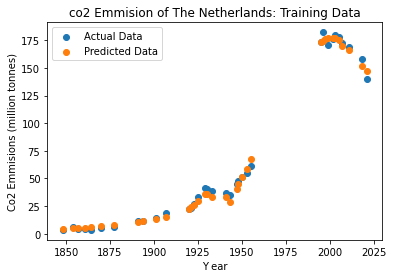

In [35]:
plt.scatter(years_co2, test_co2, label='Actual Data')
plt.scatter(years_co2, pred_co2, label='Predicted Data')
plt.title('co2 Emmision of The Netherlands: Training Data')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emmisions (million tonnes)')
plt.legend()
#plt.savefig('NLDco2Training.jpeg')

In [36]:
#jb.dump(value=NLDco2Model, filename='NLD co2 Model SVR')

In [37]:
X_p = polynldgdp.transform(nldpop)
future_nldgdp = modelnldgdp.predict(X_p)

dfnld_future = pd.DataFrame({
    'iso_code': 'NLD'*len(np.arange(2023,2101)),
    'year': np.arange(2023,2101),
    'population': np.array(nldpop['population']),
    'gdp': future_nldgdp.flatten(),
    'gdp_per_capita': future_nldgdp.flatten()/np.array(nldpop['population'])
})

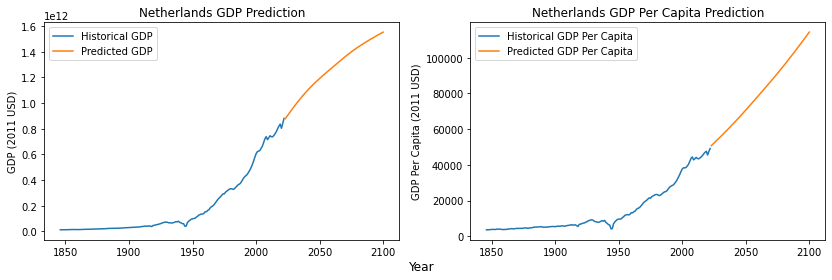

In [38]:
fig1, (ax3,ax4) = plt.subplots(1,2,sharex=True, figsize=(14,4))

ax3.plot(nld_Xgdp['year'],nld_ygdp, label='Historical GDP')
ax3.plot(dfnld_future['year'],dfnld_future['gdp'], label='Predicted GDP')
ax4.plot(dfnld['year'],dfnld['gdp_per_capita'], label='Historical GDP Per Capita')
ax4.plot(dfnld_future['year'], dfnld_future['gdp_per_capita'], label='Predicted GDP Per Capita')
fig1.supxlabel('Year')
ax3.set_ylabel('GDP (2011 USD)')
ax3.set_title('Netherlands GDP Prediction')
ax4.set_ylabel('GDP Per Capita (2011 USD)')
ax4.set_title("Netherlands GDP Per Capita Prediction")
ax3.legend()
ax4.legend()
#fig1.savefig('NLDGDPprediction.jpeg')

In [39]:
X_futco2 = dfnld_future.drop(['iso_code'], axis=1)
co2_future = modelnldco2.predict(X_futco2)
dfnld_future['co2'] = co2_future.flatten()

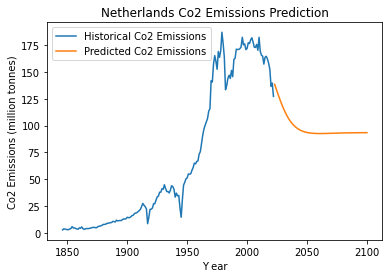

In [40]:
plt.plot(dfnld['year'],dfnld['co2'], label='Historical Co2 Emissions')
plt.plot(dfnld_future['year'],dfnld_future['co2'], label='Predicted Co2 Emissions')
plt.title('Netherlands Co2 Emissions Prediction')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('NLDco2Prediction.jpeg')

In [41]:
print('GDP per Capita:',np.array(dfnld['gdp_per_capita'])[pd.Index(dfnld['co2']).get_loc(dfnld['co2'].max())])
print('GDP:',np.array(dfnld['gdp'])[pd.Index(dfnld['co2']).get_loc(dfnld['co2'].max())])

GDP per Capita: 23313.477602558145
GDP: 327558463488.0


## Argentina

In [42]:
arg_Xgdp = dfarg[['year','population']]
arg_ygdp = dfarg['gdp']

In [43]:
#arg_gdpmodel = LinearRegression()
#arg_gdppoly = PolynomialFeatures(degree=2)

#ARGgdpModel = TrainModel(arg_gdpmodel, arg_gdppoly, arg_Xgdp, arg_ygdp,0.994)

In [44]:
ARGgdpModel = jb.load('NLD&ARG\\ARG gdp Model')

modelarggdp, polyarggdp, arg_refgdp, arg_gdp_target, arg_gdp_test, arg_gdp_test_data = ARGgdpModel
years_gdp, test_gdp, pred_gdp = arg_gdp_test_data
print(arg_gdp_test)

[0.9967945684707163, 13405607222.511456]


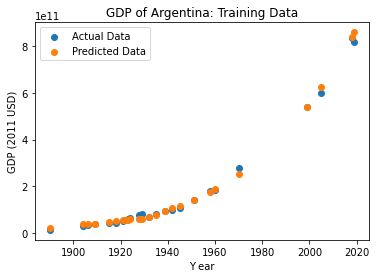

In [45]:
plt.scatter(years_gdp,test_gdp, label='Actual Data')
plt.scatter(years_gdp,pred_gdp, label='Predicted Data')
plt.title('GDP of Argentina: Training Data')
plt.xlabel('Y ear')
plt.ylabel('GDP (2011 USD)')
plt.legend()
#plt.savefig('ARGGDPTraining.jpeg')

In [46]:
#jb.dump(ARGgdpModel, filename='ARG gdp Model')

In [47]:
X_p = polyarggdp.transform(argpop)
future_arggdp = modelarggdp.predict(X_p)

dfarg_future = pd.DataFrame({
    'iso_code': 'ARG'*len(np.arange(2023,2101)),
    'year': np.arange(2023,2101),
    'population': np.array(argpop['population']),
    'gdp': future_arggdp.flatten(),
    'gdp_per_capita': future_arggdp.flatten()/np.array(argpop['population'])
})


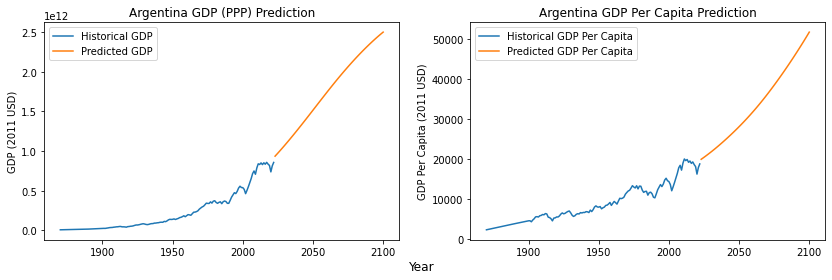

In [48]:
fig2, (ax5,ax6) = plt.subplots(1,2,sharex=True, figsize=(14,4))

ax5.plot(arg_Xgdp['year'],arg_ygdp, label='Historical GDP')
ax5.plot(dfarg_future['year'],dfarg_future['gdp'], label='Predicted GDP')
ax6.plot(dfarg['year'],dfarg['gdp_per_capita'], label='Historical GDP Per Capita')
ax6.plot(dfarg_future['year'], dfarg_future['gdp_per_capita'], label='Predicted GDP Per Capita')
fig2.supxlabel('Year')
ax5.set_ylabel('GDP (2011 USD)')
ax5.set_title('Argentina GDP (PPP) Prediction')
ax6.set_ylabel('GDP Per Capita (2011 USD)')
ax6.set_title("Argentina GDP Per Capita Prediction")
ax5.legend()
ax6.legend()
#fig2.savefig('ARGGDPPrediction.jpeg')

In [49]:
arg_Xco2 = dfarg.drop(['iso_code', 'co2'], axis=1)
arg_yco2 = dfarg['co2']

In [50]:
#arg_co2model = LinearRegression()
#arg_co2poly = PolynomialFeatures(degree=1)

#ARGco2Model = TrainModel(arg_co2model,arg_co2poly,arg_Xco2,arg_yco2, threshold=0.99)

In [51]:
ARGco2Model = jb.load('NLD&ARG\\ARG Co2 Model')

modelargco2,polyargco2, arg_refco2, arg_co2_target, arg_co2_test, arg_co2_test_data = ARGco2Model
years_co2, test_co2, pred_co2 = arg_co2_test_data
print(arg_co2_test)

[0.9931703542751918, 5.8660310180491395]


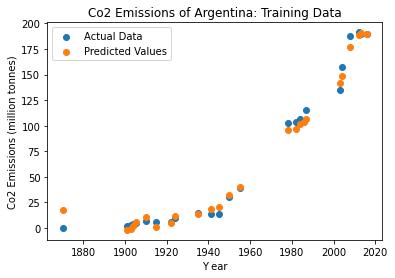

In [52]:
plt.scatter(years_co2,test_co2, label='Actual Data')
plt.scatter(years_co2,pred_co2, label='Predicted Values')
plt.title('Co2 Emissions of Argentina: Training Data')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('ARGCo2Training.jpeg')

In [53]:
#jb.dump(ARGco2Model, filename='ARG Co2 Model')

In [54]:
X_c = dfarg_future.drop(['iso_code'], axis=1)
P_c = polyargco2.transform(X_c)
pred_co2 = modelargco2.predict(P_c)
dfarg_future['co2'] = pred_co2.flatten()

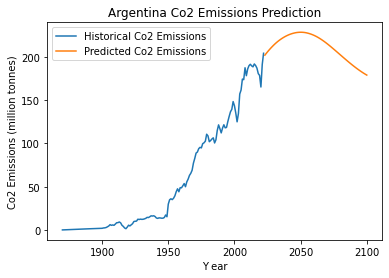

In [55]:
plt.plot(dfarg['year'],dfarg['co2'], label='Historical Co2 Emissions')
plt.plot(dfarg_future['year'],dfarg_future['co2'], label='Predicted Co2 Emissions')
plt.title('Argentina Co2 Emissions Prediction')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('ARGCo2Prediction.jpeg')

In [56]:
print('GDP per Capita:',np.array(dfarg_future['gdp_per_capita'])[pd.Index(dfarg_future['co2']).get_loc(dfarg_future['co2'].max())])
print('GDP:',np.array(dfarg_future['gdp'])[pd.Index(dfarg_future['co2']).get_loc(dfarg_future['co2'].max())])

GDP per Capita: 28152.642216855413
GDP: 1515212271850.586


## Germany and Sweden

Germany and Sweden have very similar gdp per capita, but different gdp. This will help us identify gdp as a contributing factor without gdp per capita effecting predictions.

In [57]:
deupop = pop[pop['country'] == 'Germany'][['year','population']]
dfdeu = df_co2[df_co2['iso_code'] == 'DEU']

In [58]:
swepop = pop[pop['country'] == 'Sweden'][['year','population']]
dfswe = df_co2[df_co2['iso_code'] == 'SWE']

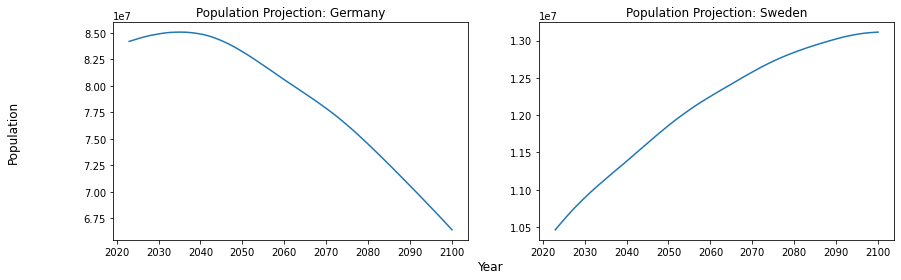

In [59]:
fig6, (ax13, ax14) = plt.subplots(1,2, sharex=True, figsize=(14,4))
ax13.plot(deupop['year'], deupop['population'])
ax14.plot(swepop['year'], swepop['population'])
ax13.set_title('Population Projection: Germany')
ax14.set_title('Population Projection: Sweden')
fig6.supxlabel('Year')
fig6.supylabel('Population')
fig6.savefig('DEUSWEpop.jpeg')

## Germany

In [60]:
deu_Xgdp = dfdeu[['year','population']]
deu_ygdp = dfdeu['gdp']

In [61]:
#deu_gdpmodel = LinearRegression()
#deu_gdppoly = PolynomialFeatures(degree=3)

#DEUgdpModel = TrainModel(deu_gdpmodel, deu_gdppoly, deu_Xgdp,deu_ygdp, threshold=0.99)

In [62]:
DEUgdpModel = jb.load('DEU&SWE\\DEU gdp Model')

modeldeugdp, polydeugdp, deu_refgdp, deu_gdp_tdeuet, deu_gdp_test, deu_gdp_test_data = DEUgdpModel
years_gdp, test_gdp, pred_gdp = deu_gdp_test_data
print(deu_gdp_test)

[0.9913455903146426, 104700414146.07043]


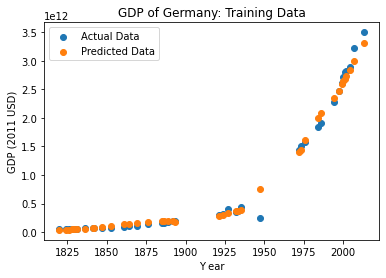

In [63]:
plt.scatter(years_gdp,test_gdp, label='Actual Data')
plt.scatter(years_gdp,pred_gdp, label='Predicted Data')
plt.title('GDP of Germany: Training Data')
plt.xlabel('Y ear')
plt.ylabel('GDP (2011 USD)')
plt.legend()
#plt.savefig('DEUGDPTraining.jpeg')

In [64]:
#jb.dump(DEUgdpModel, filename='DEU gdp Model')

In [65]:
X_p = polydeugdp.transform(deupop)
future_deugdp = modeldeugdp.predict(X_p)

dfdeu_future = pd.DataFrame({
    'iso_code': 'DEU'*len(np.arange(2023,2101)),
    'year': np.arange(2023,2101),
    'population': np.array(deupop['population']),
    'gdp': future_deugdp.flatten(),
    'gdp_per_capita': future_deugdp.flatten()/np.array(deupop['population'])
})

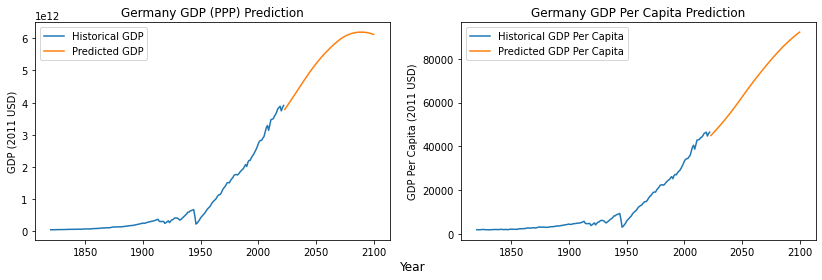

In [66]:
fig3, (ax7,ax8) = plt.subplots(1,2,sharex=True, figsize=(14,4))

ax7.plot(deu_Xgdp['year'],deu_ygdp, label='Historical GDP')
ax7.plot(dfdeu_future['year'],dfdeu_future['gdp'], label='Predicted GDP')
ax8.plot(dfdeu['year'],dfdeu['gdp_per_capita'], label='Historical GDP Per Capita')
ax8.plot(dfdeu_future['year'], dfdeu_future['gdp_per_capita'], label='Predicted GDP Per Capita')
fig3.supxlabel('Year')
ax7.set_ylabel('GDP (2011 USD)')
ax7.set_title('Germany GDP (PPP) Prediction')
ax8.set_ylabel('GDP Per Capita (2011 USD)')
ax8.set_title("Germany GDP Per Capita Prediction")
ax7.legend()
ax8.legend()
#fig3.savefig('DEUGDPPrediction.jpeg')

In [67]:
deu_Xco2 = dfdeu.drop(['iso_code','co2'], axis=1)
deu_yco2 = dfdeu['co2']

76 0.9890642800672022


Text(0.5, 1.0, 'Validation Curve')

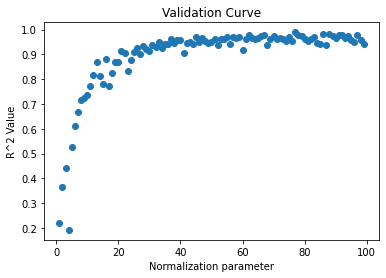

In [68]:
validation = []

for i in range(1,100):
    deu_modelco2 = SVR(C=(i+1))
    DEUco2Model = TrainSVR(deu_modelco2, deu_Xco2, deu_yco2, threshold=0.01)
    modeldeuco2, deu_refco2, deu_co2_target, deu_co2_test, deu_co2_test_data = DEUco2Model
    validation.append(deu_co2_test[0])

c_vals = np.array(range(1,100))
validation = np.array(validation)

print(validation.argmax(),validation[validation.argmax()])
plt.scatter(c_vals,validation)
plt.xlabel('Normalization parameter')
plt.ylabel("R^2 Value")
plt.title('Validation Curve')
#plt.savefig('DEUHyperparameterCurve.jpeg')

In [69]:
#deu_co2model = SVR(C=90)

#DEUco2Model = TrainSVR(deu_co2model, deu_Xco2, deu_yco2, threshold=0.99)

In [70]:
DEUgdpModel = jb.load('DEU&SWE\\DEU Co2 Model SVR')

modeldeuco2, deu_refco2, deu_co2_tdeuet, deu_co2_test, deu_co2_test_data = DEUco2Model
years_co2, test_co2, pred_co2 = deu_co2_test_data
print(deu_co2_test)

[0.9403073678216262, 85.61211008791959]


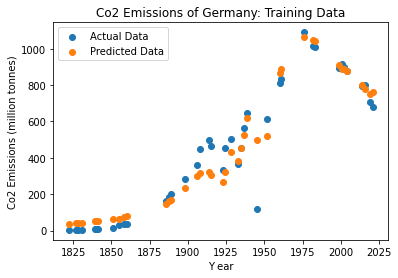

In [71]:
plt.scatter(years_co2,test_co2, label='Actual Data')
plt.scatter(years_co2,pred_co2, label='Predicted Data')
plt.title('Co2 Emissions of Germany: Training Data')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('DEUCo2Training.jpeg')

In [72]:
#jb.dump(DEUco2Model, filename='DEU Co2 Model SVR')

In [73]:
X_c = dfdeu_future[['year','population','gdp','gdp_per_capita']]
pred_co2 = modeldeuco2.predict(X_c)
dfdeu_future['co2'] = pred_co2.flatten()

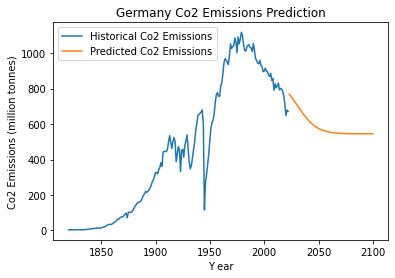

In [74]:
plt.plot(dfdeu['year'],dfdeu['co2'], label='Historical Co2 Emissions')
plt.plot(dfdeu_future['year'],dfdeu_future['co2'], label='Predicted Co2 Emissions')
plt.title('Germany Co2 Emissions Prediction')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('DEUCo2Prediction.jpeg')

In [75]:
print('GDP per Capita:',np.array(dfdeu['gdp_per_capita'])[pd.Index(dfdeu['co2']).get_loc(dfdeu['co2'].max())])
print('GDP:',np.array(dfdeu['gdp'])[pd.Index(dfdeu['co2']).get_loc(dfdeu['co2'].max())])

GDP per Capita: 22285.98721693081
GDP: 1741603078144.0


## Sweden

In [76]:
swe_Xgdp = dfswe[['year','population']]
swe_ygdp = dfswe['gdp']

In [77]:
#swe_gdpmodel = LinearRegression()
#swe_gdppoly = PolynomialFeatures(degree=2)

#SWEgdpModel = TrainModel(swe_gdpmodel, swe_gdppoly, swe_Xgdp,swe_ygdp, threshold=0.993)

In [78]:
SWEgdpModel = jb.load('DEU&SWE\\SWE gdp Model')

modelswegdp, polyswegdp, swe_refgdp, swe_gdp_tsweet, swe_gdp_test, swe_gdp_test_data = SWEgdpModel
years_gdp, test_gdp, pred_gdp = swe_gdp_test_data
print(swe_gdp_test)

[0.9938999827699633, 12668068448.693928]


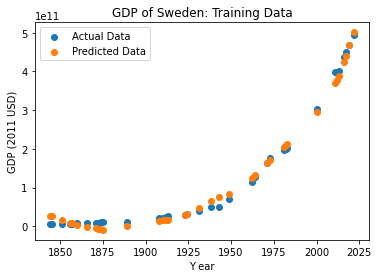

In [79]:
plt.scatter(years_gdp,test_gdp, label='Actual Data')
plt.scatter(years_gdp,pred_gdp, label='Predicted Data')
plt.title('GDP of Sweden: Training Data')
plt.xlabel('Y ear')
plt.ylabel('GDP (2011 USD)')
plt.legend()
#plt.savefig('SWEGDPTraining.jpeg')

In [80]:
#jb.dump(SWEgdpModel, filename='SWE gdp Model')

In [81]:
X_p = polyswegdp.transform(swepop)
future_swegdp = modelswegdp.predict(X_p)

dfswe_future = pd.DataFrame({
    'iso_code': 'SWE'*len(np.arange(2023,2101)),
    'year': np.arange(2023,2101),
    'population': np.array(swepop['population']),
    'gdp': future_swegdp.flatten(),
    'gdp_per_capita': future_swegdp.flatten()/np.array(swepop['population'])
})

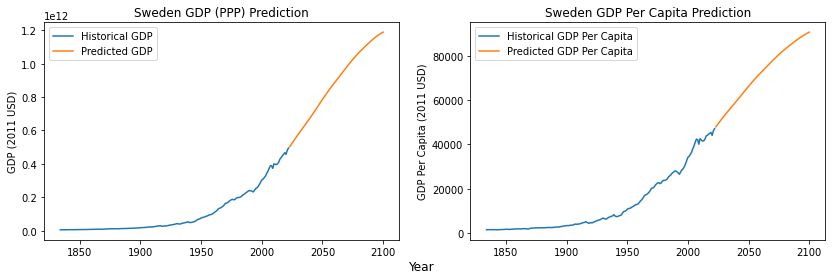

In [82]:
fig4, (ax9,ax10) = plt.subplots(1,2,sharex=True, figsize=(14,4))

ax9.plot(swe_Xgdp['year'],swe_ygdp, label='Historical GDP')
ax9.plot(dfswe_future['year'],dfswe_future['gdp'], label='Predicted GDP')
ax10.plot(dfswe['year'],dfswe['gdp_per_capita'], label='Historical GDP Per Capita')
ax10.plot(dfswe_future['year'], dfswe_future['gdp_per_capita'], label='Predicted GDP Per Capita')
fig4.supxlabel('Year')
ax9.set_ylabel('GDP (2011 USD)')
ax9.set_title('Sweden GDP (PPP) Prediction')
ax10.set_ylabel('GDP Per Capita (2011 USD)')
ax10.set_title("Sweden GDP Per Capita Prediction")
ax9.legend()
ax10.legend()
#fig4.savefig('SWEGDPprediction.jpeg')

In [83]:
swe_Xco2 = dfswe.drop(['iso_code','co2'], axis=1)
swe_yco2 = dfswe['co2']

78 0.9833092804224473


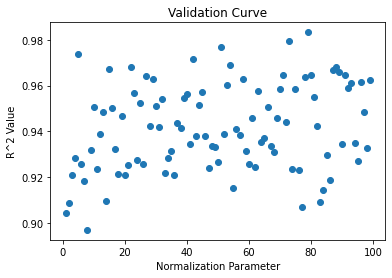

In [84]:
validation = []

for i in range(1,100):
    swe_modelco2 = SVR(C=(i+1))
    SWEco2Model = TrainSVR(swe_modelco2, swe_Xco2, swe_yco2, threshold=0.01)
    modelsweco2, swe_refco2, swe_co2_target, swe_co2_test, swe_co2_test_data = SWEco2Model
    validation.append(swe_co2_test[0])

c_vals = np.array(range(1,100))
validation = np.array(validation)

print(validation.argmax(),validation[validation.argmax()])
plt.scatter(c_vals,validation)
plt.xlabel('Normalization Parameter')
plt.ylabel("R^2 Value")
plt.title('Validation Curve')
#plt.savefig('SWEHyperparameterCurve.jpeg')

In [85]:
#swe_co2model = SVR(C=84)

#SWEco2Model = TrainSVR(swe_co2model, swe_Xco2, swe_yco2, threshold=0.98)

In [86]:
SWEco2Model = jb.load('DEU&SWE\\SWE Co2 Model SVR')

modelsweco2, swe_refco2, swe_co2_tsweet, swe_co2_test, swe_co2_test_data = SWEco2Model
years_co2, test_co2, pred_co2 = swe_co2_test_data
print(swe_co2_test)

[0.9811709194687268, 2.9293516124338517]


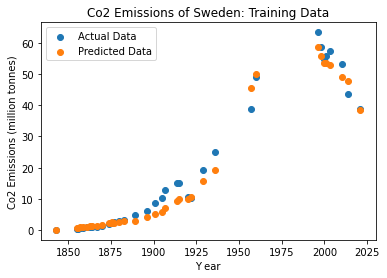

In [87]:
plt.scatter(years_co2,test_co2, label='Actual Data')
plt.scatter(years_co2,pred_co2, label='Predicted Data')
plt.title('Co2 Emissions of Sweden: Training Data')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('SWEco2Training.jpeg')

In [88]:
#jb.dump(SWEco2Model, filename='SWE Co2 Model SVR')

In [89]:
X_c = dfswe_future[['year','population','gdp','gdp_per_capita']]
pred_co2 = modelsweco2.predict(X_c)
dfswe_future['co2'] = pred_co2.flatten()

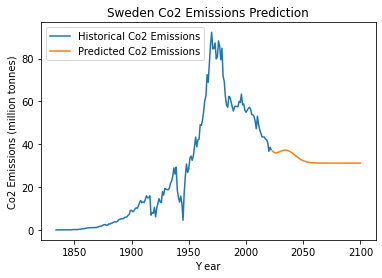

In [90]:
plt.plot(dfswe['year'],dfswe['co2'], label='Historical Co2 Emissions')
plt.plot(dfswe_future['year'],dfswe_future['co2'], label='Predicted Co2 Emissions')
plt.title('Sweden Co2 Emissions Prediction')
plt.xlabel('Y ear')
plt.ylabel('Co2 Emissions (million tonnes)')
plt.legend()
#plt.savefig('SWEco2Prediction.jpeg')

In [91]:
print('GDP per Capita:',np.array(dfswe['gdp_per_capita'])[pd.Index(dfswe['co2']).get_loc(dfswe['co2'].max())])
print('GDP:',np.array(dfswe['gdp'])[pd.Index(dfswe['co2']).get_loc(dfswe['co2'].max())])

GDP per Capita: 20269.547107761082
GDP: 163023568896.0
